In [1]:
'''
random_forest.py = here we build a random forest model to run over the K-fold CV
  Copyright (c) 2023 Charlie Payne
  Licence: GNU GPLv3
DESCRIPTION
  this notebook builds the optimal random forest model via the OptimalRF class
  it then runs the model for the dataset of your choice
NOTES
  [none]
RESOURCES
  -- https://www.datacamp.com/tutorial/random-forests-classifier-python
CONVENTIONS
  [none]
KNOWN BUGS
  [none]
DESIRED FEATURES
  [none]
'''

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
class OptimalRF():
    '''
    CLASS: OptimalRF = this finds the optimal random forest model via a grid search method
    '''
    def __init__(self, X_train: np.ndarray, X_test: np.ndarray, y_train: pd.DataFrame, y_test: pd.DataFrame,
                 nest: int, maxd: int, score: str) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.nest = nest
        self.maxd = maxd
        self.score = score
    
    def find_best_rf(self) -> None:
        '''
        METHOD: find_best_rf = this method builds the RandomizedSearchCV() to find the optimal parameters for the random forest
        '''
        param_dist = {'n_estimators': randint(1, self.nest), 'max_depth': randint(1, self.maxd)}
        
        rf = RandomForestClassifier(class_weight="balanced")
        rand_search = RandomizedSearchCV(rf,
                                         param_distributions=param_dist,
                                         scoring=self.score,
                                         n_iter=15,
                                         cv=5)
        
        rand_search.fit(self.X_train, self.y_train['class'])
        
#         self.best_est = rand_search.best_estimator_
        self.best_params = rand_search.best_params_
        print('Best hyperparameters:', self.best_params)
    
    def train_best_rf(self) -> None:
        '''
        METHOD: train_best_rf = after find_best_rf, we now train the optimal random forest using the optimal parameters
        '''
        self.rf_best = RandomForestClassifier(max_depth=self.best_params['max_depth'], n_estimators=self.best_params['n_estimators'])
        self.rf_best.fit(self.X_train, self.y_train['class'])
    
    def make_prediction(self) -> None:
        '''
        METHOD: make_prediction = now make a prediction on the test data with the optimal random forest model
        '''
        self.y_pred = self.rf_best.predict(self.X_test)
    
    def calc_scores(self) -> None:
        '''
        METHOD: calc_scores = calculate the accuracy, precision, recall, and F1-score
        '''
        self.accuracy = accuracy_score(self.y_test['class'], self.y_pred)
        self.precision = precision_score(self.y_test['class'], self.y_pred)
        self.recall = recall_score(self.y_test['class'], self.y_pred)
        self.f1 = 2*self.precision*self.recall/(self.precision + self.recall)
        
        print("Accuracy =", self.accuracy)
        print("Precision =", self.precision)
        print("Recall =", self.recall)
        print("F1 =", self.f1, '\n')
    
    def print_confusion_matrix(self) -> None:
        '''
        METHOD: print_confusion_matrix = construct the confusion matrix on the test prediction
        '''
        cm = confusion_matrix(self.y_test['class'], self.y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    def run(self) -> None:
        '''
        METHOD: run = run all the methods in order
        '''
        self.find_best_rf()
        self.train_best_rf()
        self.make_prediction()
        self.calc_scores()
        self.print_confusion_matrix()

In [3]:
def control_metrics(y_test: pd.DataFrame) -> [float, float, float, float]:
    '''
    FUNCTION: control_metrics = calculate the metrics assuming we predict only 1's, this acts as a control
          IN: y_test = the dataframe from the input data
    '''
    num_HC = len([val for val in y_test['class'] if val == 0])
    num_PD = len([val for val in y_test['class'] if val == 1])

    # assume predict only 1's, these values should be beaten by the random forest model's average metrics
    control_accuracy = (num_PD + 0)/(num_PD + num_HC + 0 + 0)  # (TP + TN)/(TP + FP + TN + FN)
    control_precision = num_PD/(num_PD + num_HC)  # TP/(TP + FP)
    control_recall = num_PD/(num_PD + 0)  # TP/(TP + FN)
    control_f1 = 2*control_precision*control_recall/(control_precision + control_recall)

    print("Control Accuracy =", control_accuracy)
    print("Control Precision =", control_precision)
    print("Control Recall =", control_recall)
    print("Control F1 =", control_f1)
    
    return control_accuracy, control_precision, control_recall, control_f1

In [4]:
# use this and the next cell to run a single test_train_split or single fold

front_dir = '../data/split/standard'

X_train = np.loadtxt(front_dir + '/X_train.csv', delimiter=',')
X_test = np.loadtxt(front_dir + '/X_test.csv', delimiter=',')
y_train = pd.read_csv(front_dir + '/y_train.csv', index_col=0)
y_test = pd.read_csv(front_dir + '/y_test.csv', index_col=0)

print('---- X_train ----')
print(X_train, '\n')
print('---- X_test ----')
print(X_test, '\n')
print('---- y_train ----')
display(y_train)
print('---- y_test ----')
display(y_test)

---- X_train ----
[[ 0.       0.84824  0.55586 ... 48.1765  45.1292  87.9815 ]
 [ 1.       0.8014   0.67329 ...  5.2919   5.0477   5.4267 ]
 [ 0.       0.21275  0.77017 ...  3.4467   2.132    7.7274 ]
 ...
 [ 0.       0.86301  0.6694  ...  7.4677   5.5853  18.6407 ]
 [ 1.       0.83735  0.72443 ... 44.88    45.0639  87.2839 ]
 [ 0.       0.78123  0.75898 ...  5.0268   9.0733  65.3693 ]] 

---- X_test ----
[[ 0.       0.16559  0.80043 ...  2.8517   3.7734   3.0523 ]
 [ 1.       0.80958  0.81445 ...  9.6665  13.8535  65.511  ]
 [ 1.       0.7593   0.7616  ...  3.2065   3.5903   4.1423 ]
 ...
 [ 0.       0.73974  0.77915 ...  3.1785   4.0573   4.0402 ]
 [ 1.       0.78904  0.78931 ... 58.1763  50.2466  95.6388 ]
 [ 0.       0.15466  0.73626 ...  7.996   10.1502  14.4655 ]] 

---- y_train ----


,class
527,1
80,0
352,1
576,0
345,1
...,...
395,0
280,1
443,1
498,1


---- y_test ----


,class
421,1
165,1
459,0
688,1
83,0
...,...
468,0
649,0
478,1
731,1


Control Accuracy = 0.743421052631579
Control Precision = 0.743421052631579
Control Recall = 1.0
Control F1 = 0.8528301886792453

Best hyperparameters: {'max_depth': 10, 'n_estimators': 20}
Accuracy = 0.8552631578947368
Precision = 0.8760330578512396
Recall = 0.9380530973451328
F1 = 0.9059829059829061 

CPU times: user 50.2 s, sys: 278 ms, total: 50.4 s
Wall time: 51.2 s


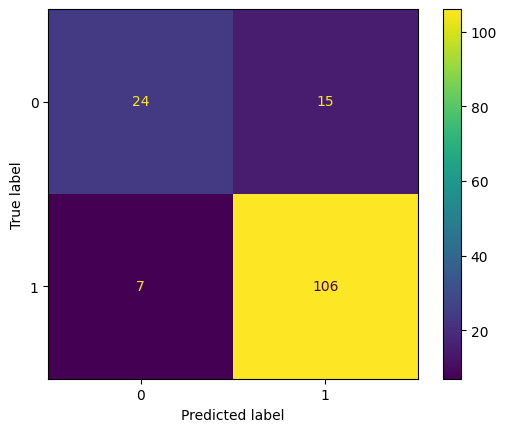

In [5]:
%%time

n_est = 200  # maximum number of trees in the random forest to optimize over
max_d = 20   # maximum depth of said trees to optimize over
metric = 'recall'  # the scoring for RandomizedSearchCV()

control_metrics(y_test)
print('')
orf = OptimalRF(X_train, X_test, y_train, y_test, n_est, max_d, metric)
orf.run()

In [ ]:
# run the above cell three times, record the numbers and find the average - there's stochasicity in RandomizedSearchCV()

print("---- metric = 'accuracy' ----")
print("AVG Accuracy =", (0.8618421052631579 + 0.8223684210526315 + 0.8355263157894737)/3)
print("AVG Precision =", (0.8650793650793651 + 0.8257575757575758 + 0.84375)/3)
print("AVG Recall =", (0.9646017699115044 + 0.9646017699115044 + 0.9557522123893806)/3)
print("AVG F1 =", (0.9121338912133892 + 0.8897959183673471 + 0.8962655601659751)/3)

print("\n---- metric = 'balanced_accuracy' ----")
print("AVG Accuracy =", (0.8421052631578947 + 0.8552631578947368 + 0.8289473684210527)/3)
print("AVG Precision =", (0.8449612403100775 + 0.8760330578512396 + 0.8320610687022901)/3)
print("AVG Recall =", (0.9646017699115044 + 0.9380530973451328 + 0.9646017699115044)/3)
print("AVG F1 =", (0.9008264462809916 + 0.9059829059829061 + 0.8934426229508197)/3)

print("\n---- metric = 'recall' ----")
print("AVG Accuracy =", (0.8552631578947368 + 0.8486842105263158 + 0.8421052631578947)/3)
print("AVG Precision =", (0.864 + 0.8571428571428571 + 0.8449612403100775)/3)
print("AVG Recall =", (0.9557522123893806 + 0.9557522123893806 + 0.9646017699115044)/3)
print("AVG F1 =", (0.907563025210084 + 0.9037656903765691 + 0.9008264462809916)/3)

In [ ]:
# F- I-- N---